<a href="https://colab.research.google.com/github/samurai921/task_sklearn/blob/master/task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача 3. Детектирование токсичных комментариев

Вам будет предоставлен корпус размеченных (0 - не токсик, 1 - токсик) текстов, где тексты представляют собой комментарии. Необходимо выполнить их семантический анализ и классифицировать на позитивные и негативные (токсичные).

Задачу можно решить как минимум двумя способами: классической текстовой моделью TF-IDF или с помощью нейронок типа BERT трансформера (суть таких нейронок в общем схожа - они делают эмбендинги слов - верктоные представления)

В качестве метрики используйте f1-меру


# Импортируем необходимые библиотеки

Импорт основных библиотек

In [9]:
import os
import re
from collections import Counter
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
import seaborn as sns

warnings.filterwarnings('ignore')

Импорт спец. библиотек

In [10]:
import nltk
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.util import bigrams, ngrams
import tensorflow as tf
from nltk.corpus import wordnet
from catboost import CatBoostClassifier
from pymystem3 import Mystem
from sentence_transformers import SentenceTransformer

импорт элементов библиотеки Scikit-Learn

In [11]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

## Подготовка данных

откроем и изучим файл

In [12]:
df = pd.read_csv('toxic_comments.csv', names=['text','toxic'], skiprows=[0])

In [13]:
df.head()

,text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим типы данных

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [15]:
df.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Итог
Датасет содержит почти 160 тыс. комментариев.

## Тип данных
Тип данных соответствует содержанию в колонка.

## Пропуски и дубликаты
Пропуски и дубликаты - отсутствуют.


## Рассмотрим распределение позитивных и негативных коментрариев

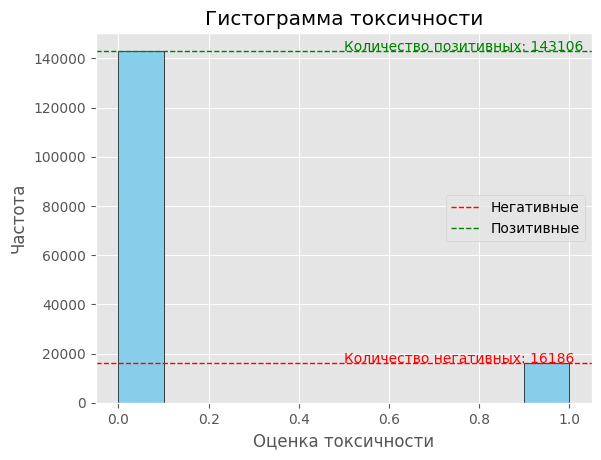

In [16]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Построение гистограммы
plt.hist(df['toxic'], bins=10, color='skyblue', edgecolor='black')

# Добавление заголовка и меток осей на русском языке
plt.title('Гистограмма токсичности')
plt.xlabel('Оценка токсичности')
plt.ylabel('Частота')

# Добавление уровней для отметки количества токсичных и нетоксичных комментариев
toxic_count = df[df['toxic'] == 1]['toxic'].count()
non_toxic_count = df[df['toxic'] == 0]['toxic'].count()

plt.axhline(toxic_count, color='red', linestyle='--', linewidth=1, label='Негативные')
plt.axhline(non_toxic_count, color='green', linestyle='--', linewidth=1, label='Позитивные')

# Добавление текста с количеством над каждой линией
plt.text(0.5, toxic_count + 10, f'Количество негативных: {toxic_count}', color='red', fontsize=10)
plt.text(0.5, non_toxic_count + 10, f'Количество позитивных: {non_toxic_count}', color='green', fontsize=10)

# Добавление легенды
plt.legend()

# Добавление сетки для лучшей читаемости
plt.grid(True)

# Отображение гистограммы
plt.show()


## Итог

Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.


## Длина комментариев

In [17]:
df['comment_length'] = df['text'].str.len()

In [18]:
df['comment_length'].describe()

count    159292.000000
mean        396.211618
std         593.777170
min           5.000000
25%          96.000000
50%         207.000000
75%         437.000000
max        5000.000000
Name: comment_length, dtype: float64

Посмотрим на распределение длины комментариев :

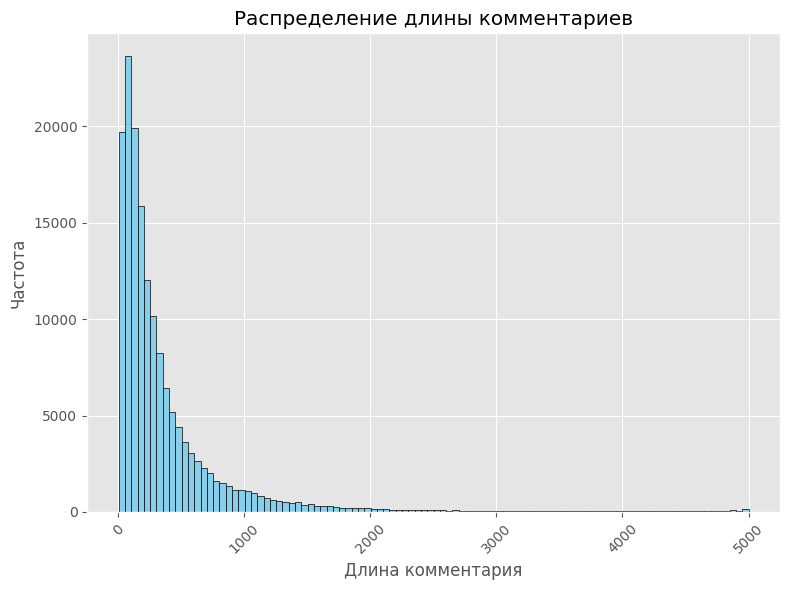

In [19]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание объекта Figure и осей
fig, ax = plt.subplots(figsize=(8, 6))

# Название графика и построение гистограммы
title = 'Распределение длины комментариев'
df['comment_length'].hist(ax=ax, bins=100, color='skyblue', edgecolor='black')

# Установка заголовка и меток осей
ax.set(title=title, xlabel='Длина комментария', ylabel='Частота')

# Добавление сетки для лучшей читаемости
ax.grid(True)

# Уменьшение перекрытия меток оси x
plt.xticks(rotation=45)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Посмотрим на распределение длины негативных и позитивных комментариев:

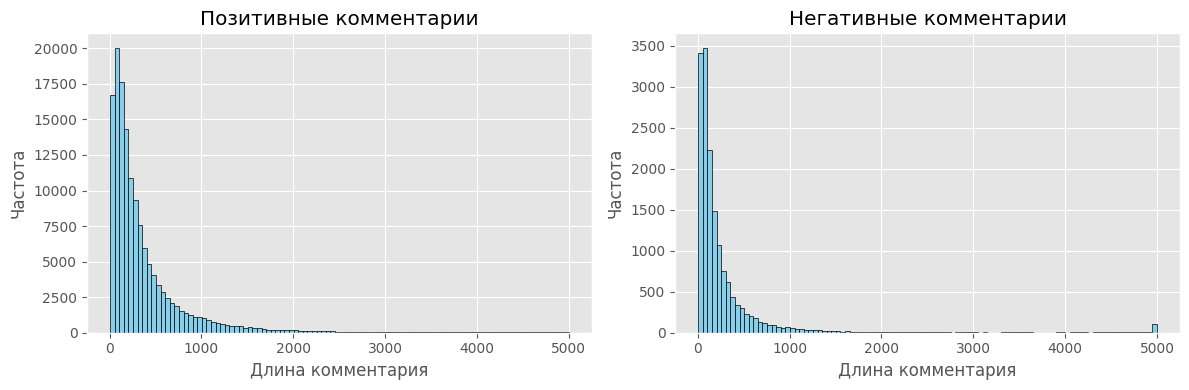

In [20]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание фигуры и осей
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Построение гистограмм для позитивных и токсичных комментариев
for i, title in enumerate(['Позитивные', 'Негативные']):
    df[df['toxic'] == i]['comment_length'].hist(ax=ax[i], bins=100, color='skyblue', edgecolor='black')
    ax[i].set(title=title + ' комментарии', xlabel='Длина комментария', ylabel='Частота')
    ax[i].grid(True)  # Добавление сетки

# Установка отступов между графиками
plt.tight_layout()

# Отображение гистограмм
plt.show()

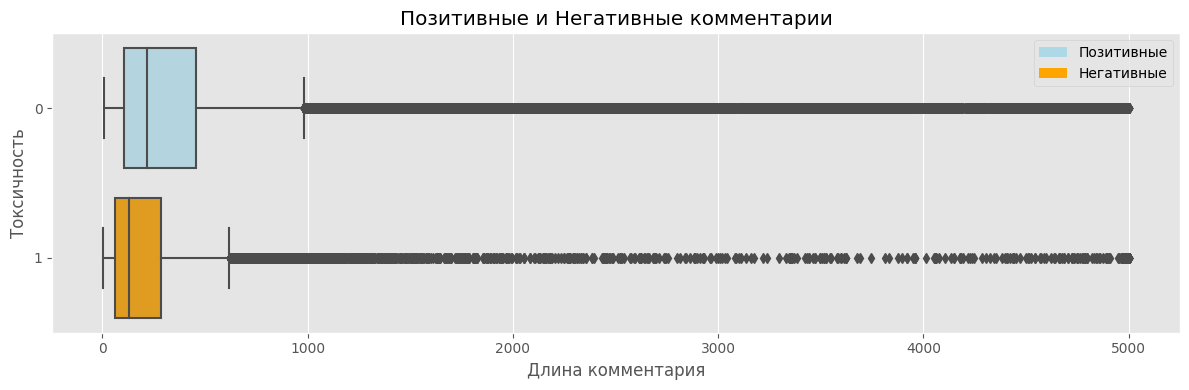

In [21]:
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(12, 4))

# Создание ящиковых графиков для позитивных и негативных комментариев
sns.boxplot(y='toxic', x='comment_length', orient='h', data=df, ax=ax, palette=['lightblue', 'orange'])

# Установка заголовка и меток осей
ax.set(title='Позитивные и Негативные комментарии', xlabel='Длина комментария', ylabel='Токсичность')

# Добавление легенды

legend_elements = [Patch(facecolor='lightblue', label='Позитивные'),
                   Patch(facecolor='orange', label='Негативные')]
ax.legend(handles=legend_elements)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Итог: ##


Отсутствуют серьезные различия в длине позитивных и негативных комментариев.

# TF-IDF (CPU)

Самый базовый подход заключается в использовании только тех слов, которые встречаются в изначальном тексте. Обучение и прогнозирование проводятся исключительно на основе словаря, составленного из слов комментариев.

Оцифровка слов осуществляется путем расчета их значимости с использованием TF-IDF. Под TF понимается количество раз, которое слово упоминается в конкретном тексте, в то время как IDF отражает частоту его употребления в общем корпусе.

Примечание: Чем выше значение TF-IDF, тем более уникальным является слово в контексте текста по сравнению с общим корпусом. Повышенная частота упоминаний в конкретном тексте и низкая частота в остальных текстах приводит к увеличению значения TF-IDF.

In [22]:
# инициализация класса для лемматизации
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WNLemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r"[a-zA-Z]+'?[a-zA-Z]+", '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Шаги, выполняемые функцией лемматизации и очистки текста, включают:

1. Разделение исходного текста на отдельные слова и символы.
2. Лемматизация отдельных слов.
3. Удаление лишних символов и цифр.
4. Избавление от дополнительных пробелов (выделение оставшихся слов в отдельные объекты).
5. Финальное объединение слов в одно предложение.

## Обработка комментариев и запись результата в отдельные файлы

In [109]:
# df['lemm_text'] = ""

# for index, row in tqdm(df.iterrows(), total=len(df)):

#     df.at[index, 'lemm_text'] = lemm_clear_text(row['text'])

In [110]:
# df.to_csv('test_preprocessed.csv', index=False)

Обработка всех комментариев заняла около Ппяти часов, поэтому результаты были сохранены в отдельные файлы.

In [23]:
read_test_df = pd.read_csv('test_preprocessed.csv')



In [24]:
print('Исходный текст:', read_test_df.loc[1, 'text'])
print('Лемматизированный:', read_test_df.loc[1, 'lemm_text'])

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный: Daww He match this background colour I m seemingly stuck with Thanks talk January UTC


В результате лемматизации теста были выявлены пропуски, представленные в виде комментариев, состоящих исключительно из цифр и символов. Такие комментарии не подлежат лемматизации, поэтому их результатом будет NaN. Примеры таких объектов приведены ниже, однако они не будут использоваться в дальнейшем анализе.

In [25]:
read_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            159292 non-null  object
 1   toxic           159292 non-null  int64 
 2   comment_length  159292 non-null  int64 
 3   lemm_text       159281 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [26]:
anomaly_index = read_test_df[(read_test_df['lemm_text'].isna()) | (read_test_df['lemm_text']=='')].index
display(read_test_df.loc[anomaly_index])
read_test_df.drop(index=anomaly_index, inplace=True)
read_test_df.reset_index(drop=True, inplace=True)

,text,toxic,comment_length,lemm_text
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,64,NaN
6289,193.61.111.53 15:00,0,20,NaN
10193,"64.86.141.133""",0,14,NaN
17280,~ \n\n68.193.147.157,0,18,NaN
38743,"88.104.31.21""",0,13,NaN
52336,"14:53,",0,6,NaN
53679,92.24.199.233|92.24.199.233]],0,29,NaN
61644,"""\n\n 199.209.144.211 """,0,22,NaN
82541,"""\n '''''' 2010/2013 """,0,21,NaN
119018,"""""""",1,5,NaN


## Биграммы и триграммы

In [27]:
read_test_df['toxic'] = read_test_df['toxic'].map({0: 'Позитивные', 1: 'Негативные'})

In [28]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
for n, name in zip([2, 3], ['Биграммы', 'Триграммы']):
    for is_clear, title in enumerate(['Негативные', 'Позитивные']):
        all_ngrams = []

        # Извлечение n-грамм из комментариев
        for words_list in read_test_df[read_test_df['toxic'] == title]['lemm_text']:
            all_ngrams.extend((list(ngrams(words_list.split(), n))))

        # Вывод наиболее часто встречающихся n-грамм
        print('{} - {} комментарии:'.format(name, title))
        print(pd.Series(all_ngrams).value_counts()[:10])
        print('\n')

Биграммы - Негативные комментарии:
(be, a)             5252
(do, nt)            2922
(I, be)             2284
(you, be)           2231
(FUCK, YOU)         1885
(NIGGER, NIGGER)    1882
(of, the)           1590
(moron, hi)         1474
(hi, moron)         1472
(I, m)              1423
Name: count, dtype: int64


Биграммы - Позитивные комментарии:
(of, the)         47822
(in, the)         33908
(be, a)           30776
(do, nt)          28964
(to, the)         25238
(it, be)          24743
(be, not)         23868
(the, article)    22716
(on, the)         21251
(to, be)          20135
Name: count, dtype: int64


Триграммы - Негативные комментарии:
(NIGGER, NIGGER, NIGGER)    1876
(hi, moron, hi)             1468
(moron, hi, moron)          1466
(faggot, faggot, faggot)    1334
(PIG, PIG, PIG)             1248
(FAT, JEW, FAT)             1226
(JEW, FAT, JEW)             1224
(SHIT, SHIT, SHIT)           998
(Bark, Bark, Bark)           998
(WANKER, WANKER, WANKER)     940
Name: count, dtype

## Рассмотрим часто встречающие слова 

Разделим позитивные и негативные комметарии

In [30]:
toxic_text = " ".join(read_test_df[read_test_df['toxic'] == 'Негативные'].text.tolist())
clear_text = " ".join(read_test_df[read_test_df['toxic'] == 'Позитивные'].text.tolist())

In [31]:
def clean_and_tokenize(text):

    words = re.findall(r'\b\w+\b', text.lower())
    return words


toxic_words = clean_and_tokenize(toxic_text)
clear_words = clean_and_tokenize(clear_text)

toxic_word_counts = Counter(toxic_words)
clear_word_counts = Counter(clear_words)


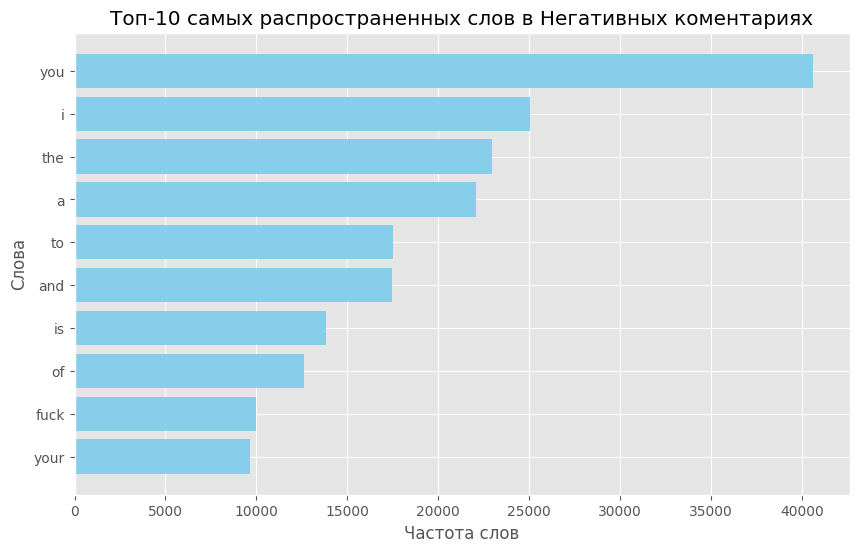

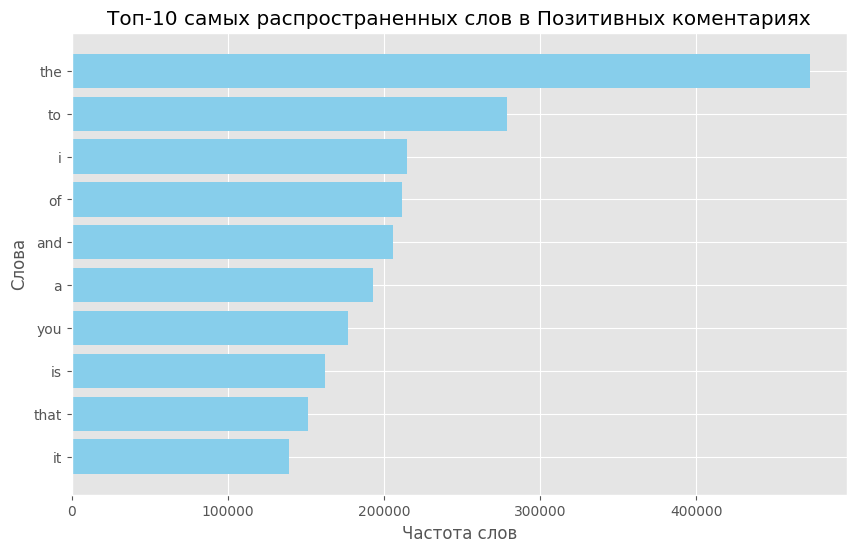

In [32]:
def plot_word_counts(word_counts, title):

    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)


    top_words = [word[0] for word in sorted_word_counts[:10]]
    top_counts = [word[1] for word in sorted_word_counts[:10]]


    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_counts, color='skyblue')
    plt.xlabel('Частота слов')
    plt.ylabel('Слова')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()


plot_word_counts(toxic_word_counts, 'Топ-10 самых распространенных слов в Негативных коментариях')

plot_word_counts(clear_word_counts, 'Топ-10 самых распространенных слов в Позитивных коментариях')


## Облако слов 

Зададим параметры для построения облака слов.

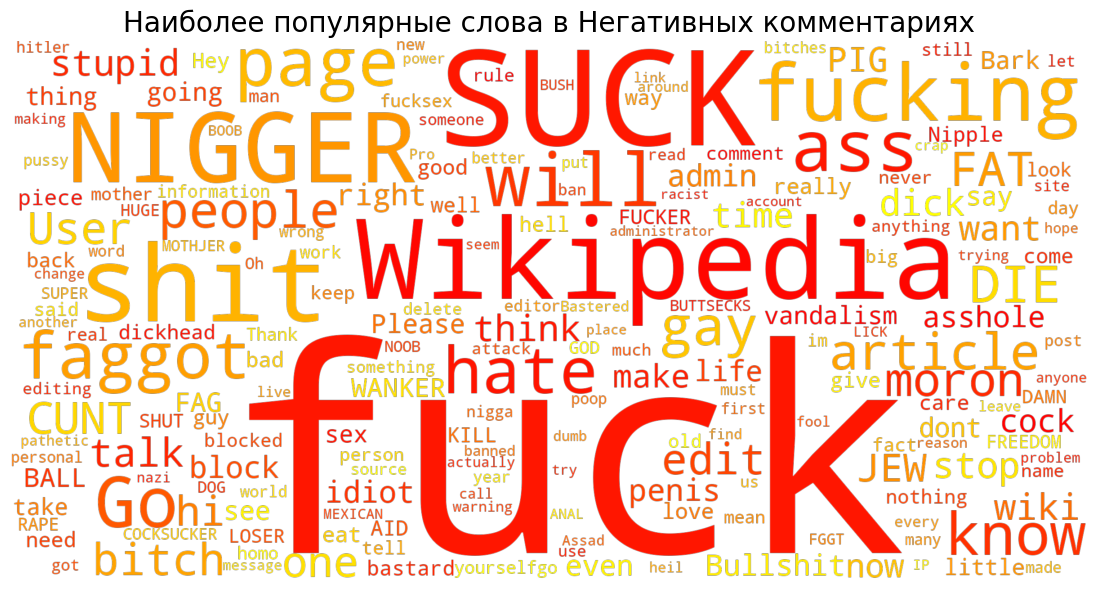

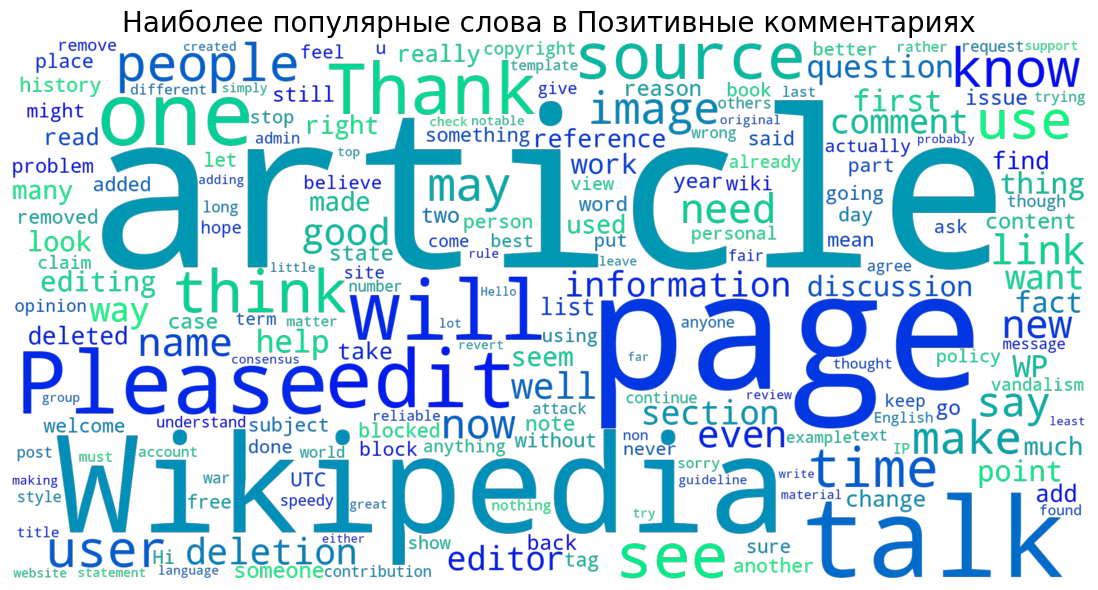

In [34]:
cloud_params = {
    'max_words': 200,
    'regexp': "[a-zA-Z]+'?[a-zA-Z]+",
    'collocations': False,
    'width': 2400,
    'height': 1200,
    'margin': 5,

    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,

    'background_color': None,
    'mode': 'RGBA',

    'random_state': 42
}

texts = [toxic_text, clear_text]
cmaps = ['autumn', 'winter']
titles = ['Негативных', 'Позитивные']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)

    # Получаем частоты слов
    frequencies = word_cloud.words_

    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title('Наиболее популярные слова в {} комментариях'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear', cmap=cmap)
    

    plt.tight_layout()
    plt.show()


## Построение модели

In [35]:
RANDOM_STATE = 42
FIG_SIZE = (7, 6)

In [36]:
read_test_df['toxic'] = read_test_df['toxic'].replace({'Позитивные': 0, 'Негативные': 1})

In [37]:
# скачивание стоп слов
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# подготовка обучающей выборки
target = read_test_df['toxic']
features = read_test_df['lemm_text']

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)

In [39]:
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 169062


Следующим этапом является тестирование обработанного текста. Учитывая наличие дисбаланса в датасете и сущность целевой метрики F1, которая отражает сбалансированность между полнотой и точностью, мы также будем выводить значения этих метрик, строить PR-кривую и анализировать значения порогов классификации.

Для оценки качества обработки текста мы сразу проведем тестирование на следующих моделях классификации:

- Логистическая регрессия (LogisticRegression);
- Классификатор CatBoost (CatBoostClassifier).

## LogisticRegression

In [40]:
# объявление модели Логистической регрессии и её гиперпараметров
LogRer_tfidf = LogisticRegression(C = 11.5,
                                  solver = 'sag',
                                  random_state = RANDOM_STATE)

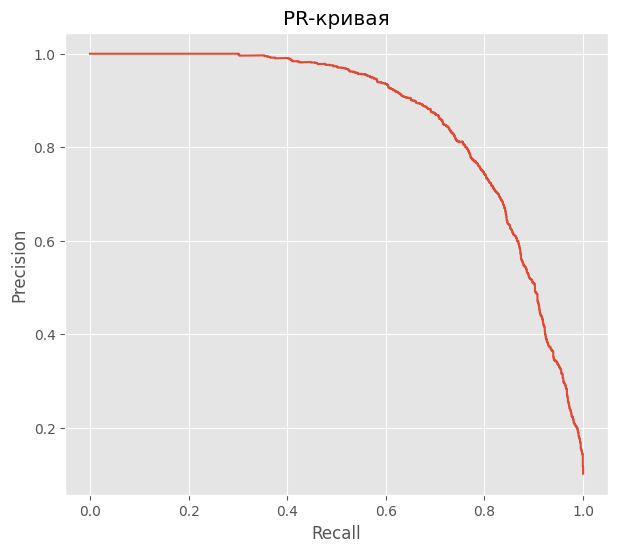

F1 = 0.773
Recall = 0.691
Precision = 0.878


In [41]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf.fit(X_train_tfidf, Y_train_tfidf)
prediction_valid = LogRer_tfidf.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

## CatBoost


In [42]:
# модель градиентного бустинга CatBoost (CPU) 16 minutes
CatBoost_tfidf = CatBoostClassifier(verbose = 100, # шаг вывода информации о процессе обучения
                                    task_type = 'CPU', # среда работы модели
                                    max_depth = 3, # макс. глубина базовых моделей
                                    learning_rate = 0.9, # шаг градиентного бустинга
                                    eval_metric = 'F1') # метрика оценки модели

In [43]:
# обучение CatBoost на фичах TF-IDF
CatBoost_tfidf.fit(X_train_tfidf, Y_train_tfidf)

0:	learn: 0.4062195	total: 379ms	remaining: 6m 18s
100:	learn: 0.7767888	total: 22.5s	remaining: 3m 20s
200:	learn: 0.8047257	total: 44.8s	remaining: 2m 58s
300:	learn: 0.8229351	total: 1m 6s	remaining: 2m 35s
400:	learn: 0.8356913	total: 1m 28s	remaining: 2m 12s
500:	learn: 0.8420790	total: 1m 50s	remaining: 1m 50s
600:	learn: 0.8452272	total: 2m 13s	remaining: 1m 28s
700:	learn: 0.8448820	total: 2m 35s	remaining: 1m 6s
800:	learn: 0.8465503	total: 2m 57s	remaining: 44.1s
900:	learn: 0.8486938	total: 3m 19s	remaining: 22s
999:	learn: 0.8580768	total: 3m 41s	remaining: 0us


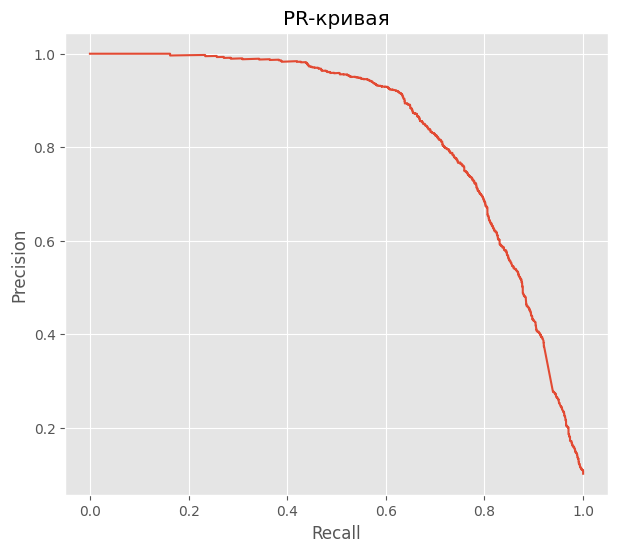

F1 = 0.752
Recall = 0.671
Precision = 0.856


In [44]:
# тестирование TF-IDF на CatBoost
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

## Итог:

Лемматизация текста занимает около нескольких часов (5 часов) и не зависит от использования графического процессора.
Процесс векторизации подготовленного текста с помощью TfidfVectorizer осуществляется мгновенно. Удалены слова, не несущие смысловой нагрузки.
Значение целевой метрики F1 для логистической регрессии составляет 0.773.
Для градиентного бустинга CatBoost значение F1 равно 0.752, однако время обучения на CPU составляет 7 минут. Использование GPU требует большого объема оперативной памяти, что невозможно на базовых мощностях Google Colab.
Основным недостатком является большое количество признаков и объем памяти, необходимый для их хранения. Это усложняет использование GPU для ускорения обучения модели CatBoost.
На данный момент результаты тестирования считаются приемлемыми, однако следует учитывать наличие дисбаланса классов. Этому вопросу будет уделено внимание в отдельном разделе.

## SentanceTranformer (GPU)

В данном разделе будет использован альтернативный метод преобразования. В отличие от TF-IDF векторизатора, предобученная модель для SentenceTransformer учитывает контекст. Она способна создавать векторы, сохраняющие контекст комментариев.

Благодаря меньшему количеству признаков и требуемому объему оперативной памяти, возможно применение GPU для ускорения работы с большими объемами данных.

In [132]:
# инициализация предобученной модели преобразования текста в вектора
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [133]:
# назначение GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [134]:
%%time
# кодирование текста
ST_embeddings = []

if  device_name == '/device:GPU:0':
    with tf.device('/device:GPU:0'):
        ST_embeddings = sentence_transformer.encode(read_test_df['text'])
else:
    for i in tqdm(range(len(read_test_df['text']))):
        ST_embeddings.append(sentence_transformer.encode(read_test_df.loc[i, 'text']))

CPU times: user 3min 38s, sys: 1.39 s, total: 3min 39s
Wall time: 3min 19s


In [135]:
pd.DataFrame(ST_embeddings).head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.028033,0.056780,0.091350,0.032315,0.048531,0.024905,-0.001665,-0.035811,0.015926,-0.019791,...,-0.001887,0.004119,0.005928,0.077336,-0.058341,-0.031362,0.001371,0.014139,-0.026163,-0.041901
1,-0.051320,0.087537,0.055453,-0.061086,0.071453,-0.035208,0.104684,-0.090926,-0.009080,-0.010960,...,0.082233,-0.088611,0.035271,0.029772,0.046203,0.039858,0.092982,0.020118,-0.092164,0.018549
2,0.010958,0.092103,0.051115,0.013316,0.018948,0.023738,-0.033800,-0.098386,0.031458,0.026289,...,-0.015570,0.027781,0.109071,0.068101,0.047131,0.015144,0.022232,-0.060034,0.014200,0.009034
3,-0.009012,-0.036221,0.051822,0.067826,0.083256,0.101421,-0.041176,0.040358,-0.090684,0.007777,...,0.019424,0.046546,0.025812,-0.015300,0.046243,-0.013108,0.030476,0.031271,0.016119,0.054877
4,-0.108289,-0.002620,-0.120247,-0.031936,0.018257,0.051597,-0.008284,-0.025604,-0.056420,0.014543,...,-0.022339,-0.015537,0.059215,-0.016928,0.009169,-0.014318,0.112808,0.089494,-0.086648,-0.038295


In [136]:
# подготовка обучающей выборки
target = read_test_df['toxic']
features = ST_embeddings

# выделение тренировочной выборки
X_train_emb, X_other, Y_train_emb, Y_other = train_test_split(features,
                                                              target,
                                                              stratify = target,
                                                              train_size = 0.80,
                                                              random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_emb, X_test_emb, Y_valid_emb, Y_test_emb = train_test_split(X_other,
                                                                    Y_other,
                                                                    stratify = Y_other,
                                                                    test_size = 0.50,
                                                                    random_state = RANDOM_STATE)

print('Количество признаков:', X_train_emb.shape[1])

Количество признаков: 384


## LogisticRegression

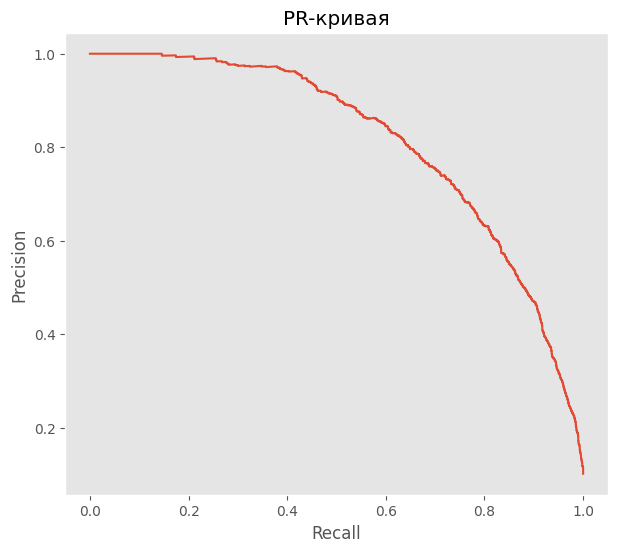

F1 = 0.703
Recall = 0.609
Precision = 0.831


In [137]:
# тестирование SentanceTranformer на Logistic Regression
LogRer_emb = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_emb.fit(X_train_emb, Y_train_emb)
prediction_valid = LogRer_emb.predict(X_valid_emb)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

## CatBoost (CPU)

In [50]:
# модель градиентного бустинга CatBoost
CatBoost_cpu_emb = CatBoostClassifier(verbose = 100,
                                      task_type = "CPU",
                                      eval_metric = 'F1', # метрика оценки модели
                                      early_stopping_rounds = 200) # макс. кол-во итераций обучения

In [ ]:
# обучение CatBoost на фичах SentanceTranformer (CPU)
CatBoost_cpu_emb.fit(X_train_emb, Y_train_emb)

In [ ]:
# тестирование SentanceTranformer на CatBoost (CPU)
prediction_valid = CatBoost_cpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_cpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

## CatBoost (+ GPU)

In [138]:
# модель градиентного бустинга CatBoost (GPU)
CatBoost_gpu_emb = CatBoostClassifier(verbose = 100,
                                      task_type = "GPU",
                                      eval_metric = 'F1',
                                      early_stopping_rounds = 200)

In [139]:
# обучение CatBoost на фичах SentanceTranformer (GPU)
CatBoost_gpu_emb.fit(X_train_emb, Y_train_emb)

Learning rate set to 0.025822
0:	learn: 0.3188737	total: 22.7ms	remaining: 22.7s
100:	learn: 0.4994979	total: 1.41s	remaining: 12.5s
200:	learn: 0.5980303	total: 2.65s	remaining: 10.5s
300:	learn: 0.6394728	total: 3.87s	remaining: 8.98s
400:	learn: 0.6605998	total: 7.52s	remaining: 11.2s
500:	learn: 0.6745899	total: 8.88s	remaining: 8.84s
600:	learn: 0.6871132	total: 10.1s	remaining: 6.69s
700:	learn: 0.6967931	total: 11.4s	remaining: 4.84s
800:	learn: 0.7045600	total: 15.2s	remaining: 3.77s
900:	learn: 0.7120018	total: 16.3s	remaining: 1.79s
999:	learn: 0.7188877	total: 17.4s	remaining: 0us


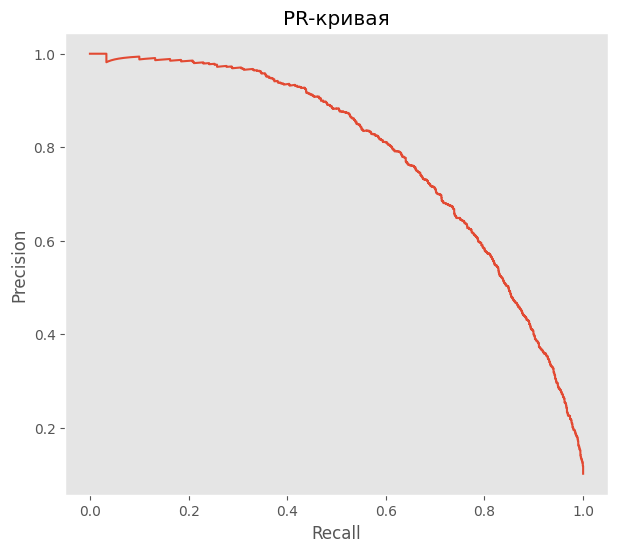

F1 = 0.665
Recall = 0.551
Precision = 0.841


In [140]:
# тестирование SentanceTranformer на CatBoost (GPU)
prediction_valid = CatBoost_gpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_gpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

## Итог:

Кодирование текста (генерация эмбеддингов) с использованием GPU и предобученной модели из SentenceTransformer занимает 3,5 минуты (в сравнении с 2 часами на CPU).
- Логистическая регрессия демонстрирует F1 = 0.70 с небольшим временем общей работы: 20 секунд (включая обучение и предсказание).
- Для градиентного бустинга CatBoost на CPU значение F1 составляет 0.71, а время обучения — 4,5 минуты.
- Градиентный бустинг CatBoost на GPU показывает F1 = 0.68 и время обучения 25 секунд.
Это предварительные результаты, которые будут дополнительно рассмотрены в следующем разделе с учетом дисбаланса классов.

## Борьба с дисбалансом

### Баланс классов
Использование встроенных средств модели, позволяющие стабилизировать разность между классами назначив им разные веса.

In [45]:
# объявление Логистической регрессии с балансом классов
LR_balanced = LogisticRegression(solver = 'sag',
                                 class_weight = 'balanced',
                                 random_state = RANDOM_STATE)

In [46]:
# тестирование TF-IDF на Logistic Regression + баланс классов
LR_balanced.fit(X_train_tfidf, Y_train_tfidf)
balanced_prediction_valid = LR_balanced.predict(X_valid_tfidf)

print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, balanced_prediction_valid)))

F1 = 0.743
Recall = 0.846
Precision = 0.662


In [ ]:
# тестирование SentanceTranformer на Logistic Regression + баланс классов
LR_balanced.fit(X_train_emb, Y_train_emb)
balanced_prediction_valid = LR_balanced.predict(X_valid_emb)

print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, balanced_prediction_valid)))


Если ранее наблюдались низкие значения полноты (Recall), то балансировка классов путем изменения их весов могла изменить ситуацию на противоположную. Метрика F1 осталась на прежнем уровне или даже ухудшилась.

## Изменение порога классификации

В датасете присутствуют 2 класса, и изначально объекты распределяются между ними с вероятностью 50%. Однако в данном случае соотношение классов составляет 1:9 в пользу одного из них (токсичные комментарии). В этом разделе будет проводиться смещение порога классификации для повышения качества предсказаний.

In [48]:
# тестирование TF-IDF на Logistic Regression + смещение порога классификации (2 minutes)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

100%|██████████| 15830/15830 [00:57<00:00, 274.65it/s]

Наивысший показатель F1 = 0.783, при смещении порога до значения 0.32


In [ ]:
# тестирование SentanceTranformer на Logistic Regression + смещение порога классификации (2:20 minutes)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_emb, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

In [49]:
# CatBoost TF-IDF + смещение порога классификации (1 minutes)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

100%|██████████| 10663/10663 [00:38<00:00, 278.55it/s]

Наивысший показатель F1 = 0.760, при смещении порога до значения 0.31


In [ ]:
# CatBoost SentanceTransformer + смещение порога классификации (2 minutes)
proba_valid = CatBoost_cpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_emb, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

Изменение порога классификации является эффективным способом учета дисбаланса классов и увеличения количества правильно классифицированных объектов.

## Уменьшение выборки (DownSampling)

In [53]:
# деление признаков по классам
target_1   = Y_train_tfidf[Y_train_tfidf == 1]
target_0   = Y_train_tfidf[Y_train_tfidf == 0]
features_1 = read_test_df.loc[target_1.index, 'lemm_text']
features_0 = read_test_df.loc[target_0.index, 'lemm_text']

# уменьшение выборки многочисленного класса
Y_downsampled = pd.concat([target_0.sample(frac=(1/9),   random_state=RANDOM_STATE)] + [target_1])
X_downsampled = pd.concat([features_0.sample(frac=(1/9), random_state=RANDOM_STATE)] + [features_1])
X_downsampled = count_tf_idf.transform(X_downsampled)

In [54]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf_sd = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_tfidf_sd.fit(X_downsampled, Y_downsampled)
prediction_valid = LogRer_tfidf_sd.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf_sd.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

F1 = 0.688
Recall = 0.852
Precision = 0.577


In [55]:
# обучение CatBoost на ресемплированных фичах TF-IDF
CatBoost_tfidf_sd = CatBoostClassifier(verbose = 100, eval_metric = 'F1', early_stopping_rounds = 200)
CatBoost_tfidf_sd.fit(X_downsampled, Y_downsampled)

Learning rate set to 0.041186
0:	learn: 0.4994520	total: 175ms	remaining: 2m 54s
100:	learn: 0.8015079	total: 16.7s	remaining: 2m 28s
200:	learn: 0.8390725	total: 33.1s	remaining: 2m 11s
300:	learn: 0.8607756	total: 49.4s	remaining: 1m 54s
400:	learn: 0.8781343	total: 1m 5s	remaining: 1m 38s
500:	learn: 0.8903306	total: 1m 22s	remaining: 1m 21s
600:	learn: 0.8994418	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.9054816	total: 1m 55s	remaining: 49.3s
800:	learn: 0.9109040	total: 2m 12s	remaining: 32.9s
900:	learn: 0.9171360	total: 2m 29s	remaining: 16.4s
999:	learn: 0.9210867	total: 2m 46s	remaining: 0us


In [56]:
# тестирование TF-IDF на CatBoost (CPU)
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

F1 = 0.752
Recall = 0.671
Precision = 0.856


Снижение размера выборки не привело к улучшению значений рассматриваемых метрик, и на самом деле это скорее искусственный результат, так как он не учитывает реальную ситуацию.

## Итоговое тестирование

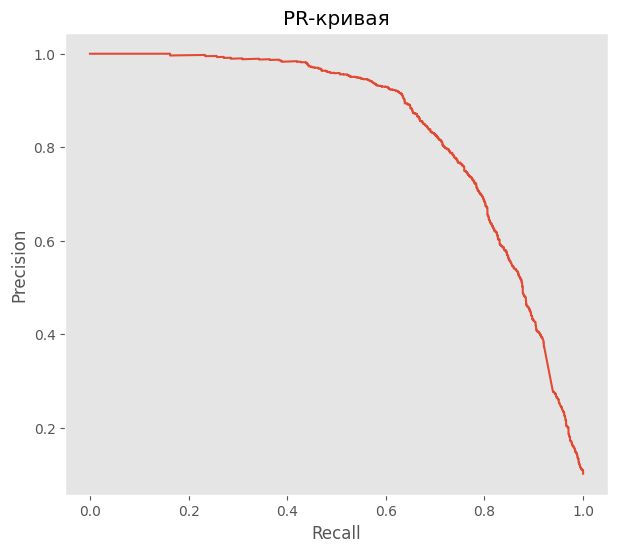

F1 = 0.781
Recall = 0.788
Precision = 0.774


In [57]:
# финальный тест TF-IDF на Logistic Regression + смещение порога классификации
proba_test = LogRer_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.25
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

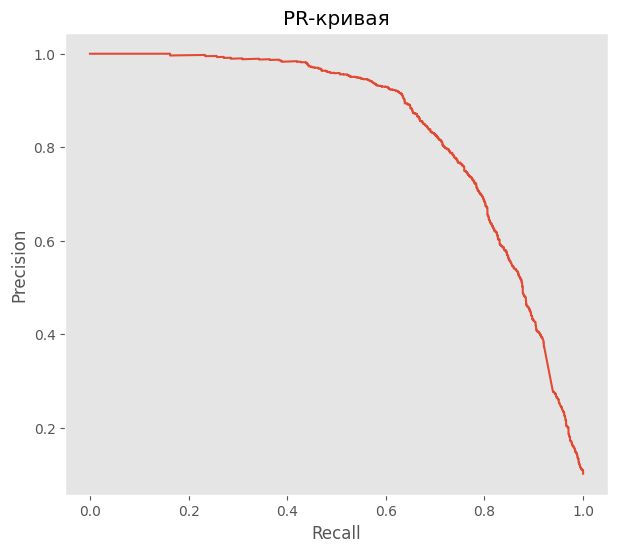

F1 = 0.773
Recall = 0.709
Precision = 0.850


In [58]:
# финальный тест TF-IDF на CatBoost + смещение порога классификации
proba_test = CatBoost_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.49
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

## Выводы:

При оценке модели следует учитывать следующие основные критерии:

1. Затраты времени и ресурсов на кодирование текста.
2. Затраты времени и ресурсов на обучение модели.
3. Время, требуемое для предсказаний.
4. Значение итоговой метрики.

Логистическая регрессия, использующая TF-IDF векторизатор, демонстрирует наилучший результат (F1 = 0.77). Подготовка и кодирование текста занимают около 25 минут, обучение регрессии — 20 секунд, а предсказание — мгновенное. Для работы данной комбинации моделей не требуется использование GPU в качестве аппаратного ускорителя. Итоговое значение метрики F1 выше для логистической регрессии, кроме того, значения метрик Recall и Precision более сбалансированы.

Модель CatBoost может предоставить прогнозы более высокого качества, но для этого требуется более тщательная настройка гиперпараметров и дополнительное время. Процесс сильно зависит от технических характеристик компьютера или сервера.